# Custom dataset, dataloader


## data set

## 목표

```python
## 목표

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


```


# Randomness Controll

## 1. torch.manual_seed(random_seed)
위와 같이 한 줄만 입력해주면 torch.블라블라 를 통해 발생하는 randomness들이 통제가 됩니다. 다만 CUDA 함수를 사용하는 PyTorch 함수들 중에 nondeterministic한 함수가 존재한다고 합니다. 대표적인 예시가 atomic operation, 그 중에서도 atomicAdd 인데요, 이 연산이 포함되어있는 함수들은 대표적으로 forward kernel 중에는 torch.Tensor.index_add_() , torch.Tensor.scatter_add_() , torch.bincount() 연산이 있고, backward kernel 중에는 torch.nn.functional.embedding_bag() , torch.nn.functional.ctc_loss() , torch.nn.functional.interpolate() 이 존재한다고 합니다.

이 6가지 연산을 사용하고 계시다면, 현재로서는 nondeterminism을 피할 방법이 없다고 합니다! ㅠㅠ

## 2.CuDNN

 CuDNN은 딥러닝에 특화된 CUDA library로 주로 환경 설정을 할 때 CUDA와 CuDNN을 함께 설치하고, 대부분 딥러닝 프레임워크에서 필수적으로 사용되는 라이브러리

 ## 3. Numpy

 Scikit-learn 등 딥러닝에 도움이 되는 주요 라이브러리도 Numpy를 backend로 사용하고 있고, PyTorch로 코드를 짤 때 대부분 Numpy로 data를 받아오고, metric을 계산하는 경우가 많아서 Numpy의 random seed도 고정을 해주어야 합니다. 마찬가지로 1줄로 random seed를 설정할 수 있습니다.

```python
 np.random.seed(random_seed)
```

## 4. Random

아직 하나 더 남았습니다. dataset 구성할 때 사용한 torchvision의 transforms 함수 때문이었습니다.
torchvision의 transforms를 대부분 사용하실 텐데 이 경우에는 마지막으로 python random 라이브러리도 randomness를 제어해주셔야 합니다.

```python
random.seed(random_seed)
```

---

### randomness 제어하는 이유

contrastive learning을 하기 위해서, 지금 Positive traindataset을 하나 더 만드려고 합니다.

먼저 똑같이 2개를 만들고 image에는 tranforms를 가하고, text에는 title데이터와 섞어서 더 넣어주려고 합니다.

In [75]:
import torch
import numpy as np
import random 
RANDOMNESS = False

random_seed = 77

if RANDOMNESS == True:
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
## SHUFFLE

SHUFFLE = False

### 조금더 간단한 dataset을 준비했다.

### preprocessed image와 tokenize된 title의 쌍 데이터셋이다.

## dataset 준비

## image, title list 준비


In [76]:
import pandas as pd
import os
img_dir = '/Users/juniverse/Desktop/pointcloud/VectorUniverse/Data/thumbnails/images/'
data = pd.read_csv('/Users/juniverse/Desktop/pointcloud/VectorUniverse/Data/Youtube_thumbnails/metadata.csv')

# 이미지 파일 목록 생성
img_list = []
id_list = []
for file in os.listdir(img_dir):
    ch_dir = os.path.join(img_dir,file)
    for images in os.listdir(ch_dir):
        # print(images)
        if images.endswith('.jpg'):
            img_list.append(os.path.join(ch_dir, images))
            img_id = images.split('.jpg')[0]
            id_list.append(img_id)

# 이미지 파일 목록 출력
# print(img_list)
print(id_list) # 2303 

text_list = []
cat_list = []
ch_list = []

for i in id_list:
    text_list.append(data[data["Id"]==i]['Title'].values[0])
    cat_list.append(data[data["Id"]==i]['Category'].values[0])
    ch_list.append(data[data["Id"]==i]['Channel'].values[0])

# 아래 다섯가지로 만들 수 있음. 이미지가 부족해서 이미지를 기준으로 만듬. 
# img_list = []
# id_list = []
# text_list = []
# cat_list = []
# ch_list = []
new_list = []
for cat,text in zip(cat_list,text_list):
    new_list.append(cat+', '+text)
    
    

['l0IefQRFVfE', 'pYy5-KowMj0', '015wj1C5wK0', 'VnIsuYVlSls', 'C0f2pu0EVSg', '3kJPxsELVAk', 'MGGhz29kYYA', 'gtXpRZUAc1o', 'qNxQRgsF2NA', 'bdUVehx6UBU', 'WTxTBFU7Sdk', 'pF2mNC4EXfA', 'gKZPPYWTtvc', 'dojhP_1W5tA', 'iokVvwcut5o', '6L-BogO6HwU', 'cvHkteWF5GM', 'y1XbPl1XB44', 'BDd-5qCiL-A', 'AfjrpjqdQxI', 'ZAYZWgGxKO4', '0EhcAzhauRM', '5HInaJxFxWs', 'I6w5AN_Wcak', 'oMA7o8olHzY', 'Gy4QHTgikbk', '3xH1vBuDbBA', 'yiMlzXMr0KU', 'RoVnb_TlJ8A', 'A0Lf8eP41vs', 'tj1D9KAYV1E', 'ipRvjS7q1DI', 'RYSvCb14JjU', 'u3Mqvex6tIE', 'dLyt7H7gyhI', 'kEIvicUmegs', 'UNbgIxL3PyM', '52GCI7rqV4A', 'KoihlAl7ugQ', 'Lwq2WfpY-ss', 'YLWjn0TFH3U', 'mTztlpAcips', '1GfuKF4uENc', 'N5SrDhe4bE0', 'X2jakwIVLbY', '_bggaA5AURA', 'NGbFtTYQpus', 'z2qNEOnlxjA', 'uyU-lKE0Go8', 'oAADFdfa-G4', 'Jl0IDXkYKbk', 'P09pTe54uKM', 'AQWeO5wMekQ', 'RyLXLFaspj0', 'mqZS-hEPE6k', '39ii9LvnDoE', '0xPwHR8_D2w', 'REhLHpdLCE0', 'PDkC1eebWbU', 'qpipLfMiaYU', 'Ev3__YJJH3M', 'YNaBoKLX52M', 'JzWtoP1Xhc0', '5pAnk9MKHzo', 'IbgPYS3RnTA', 'Z4BKrSazQh0', 'FWYsvw_U

# Dataset


/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/var/folders/j9/psjfyfss16v_xrrj6mh5sw0h0000gn/T/ipykernel_23529/3685041147.py:60: UserWarning: To copy construct fro

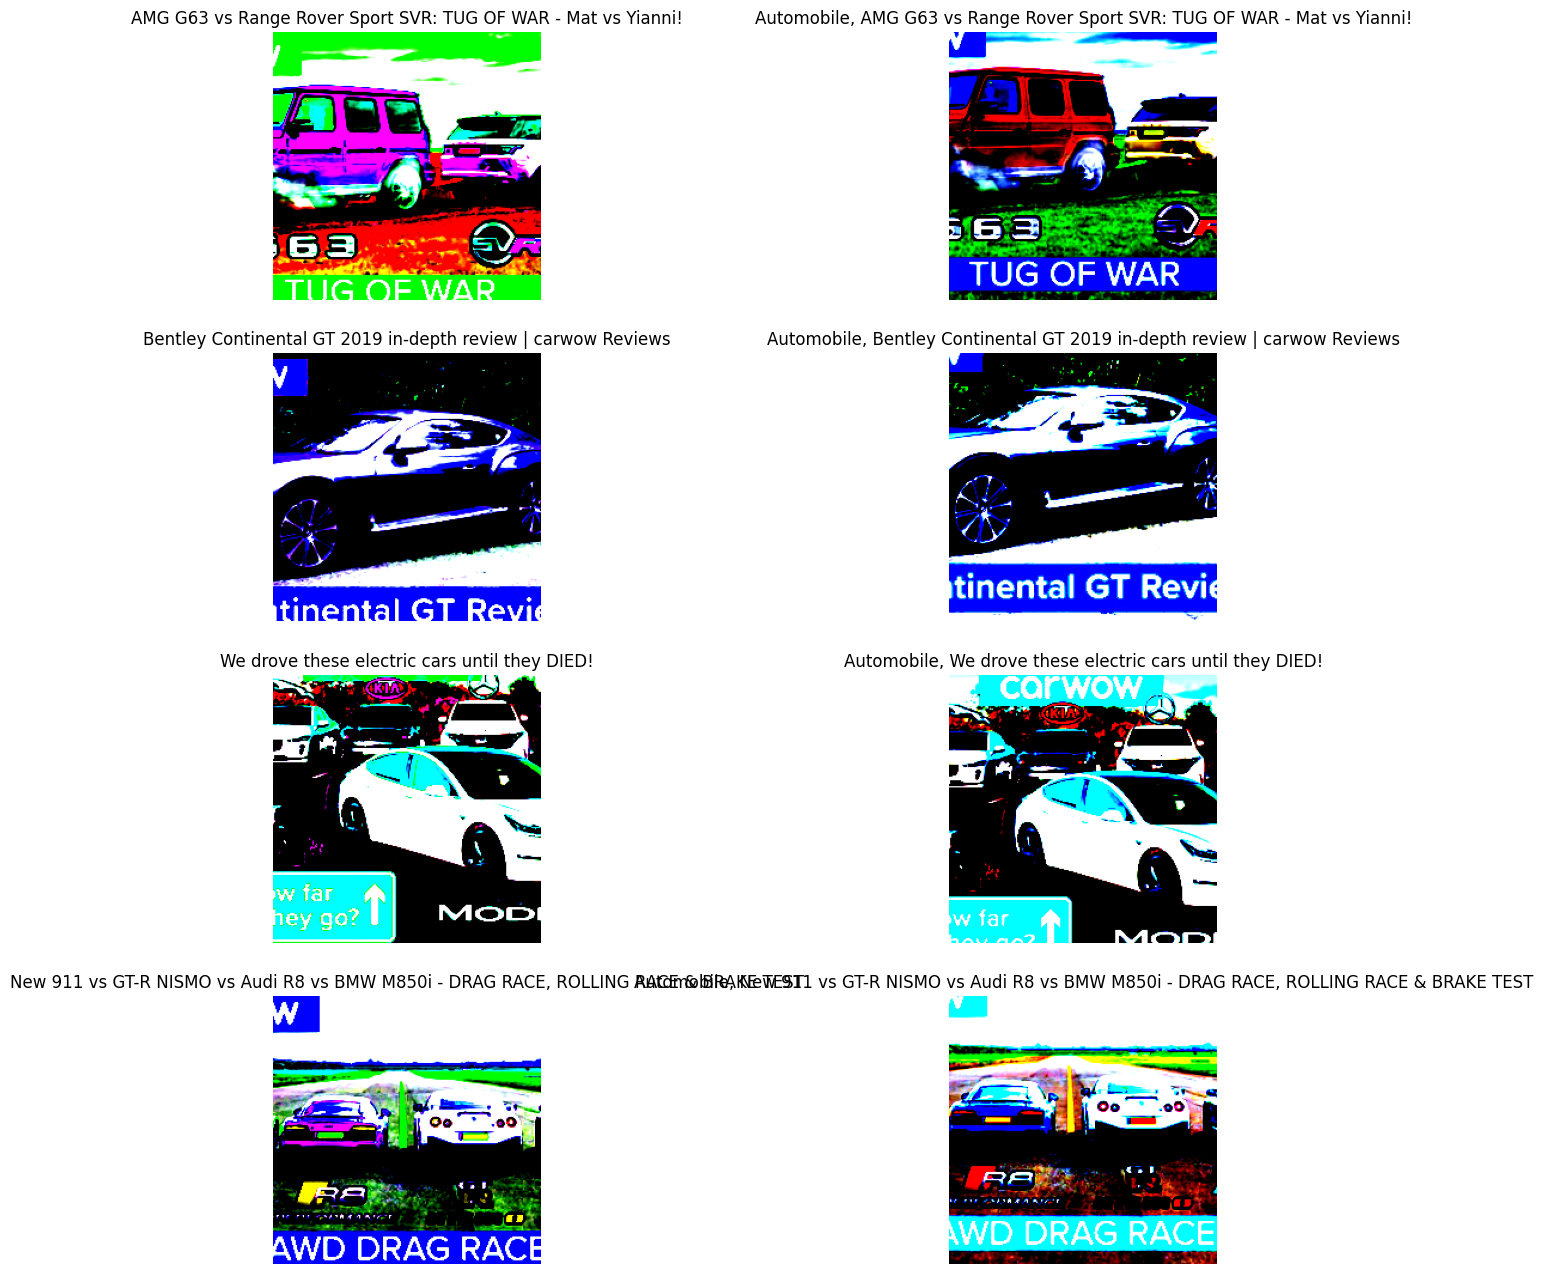

In [77]:
import matplotlib.pyplot as plt
import pandas as pd
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader

import os
import json
from PIL import Image
from tqdm import tqdm
import clip
import requests
from transformers import CLIPProcessor, CLIPModel,AutoProcessor, AutoTokenizer

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

####### example of tokenizer and processor
"""
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
images = processor(images=image, return_tensors="np")
title = tokenizer(["a photo of a cat and a photo of a dog"], padding=True, return_tensors="np")
"""

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class image_title_dataset(Dataset):
    def __init__(self, list_image_path,list_txt,transforms):
        # Initialize image paths and corresponding title
        self.image_path = list_image_path
        
        # Tokenize text using CLIP's tokenizera
        self.title = tokenizer(text=list_txt, padding=True, return_tensors="pt")
        self.transform = transforms
        
    def __len__(self): #split 할때 여기가 중요함.
        return len(self.image_path)

    def __getitem__(self, idx):
        
        # tokenize text token make as (batch_size,77)
        total_length = self.title['input_ids'].shape[0]
        rest_token_num = 77-self.title['input_ids'].shape[1]
        dummy = torch.ones(total_length,rest_token_num)*49407
        text_token_tensor = torch.concat((self.title['input_ids'],dummy),dim=1)
        text_token_tensor = text_token_tensor.type(torch.int32)
        
        
        # Preprocess image using CLIP's preprocessing function
        image = Image.open(self.image_path[idx])
        image = processor(images=image, return_tensors="pt")['pixel_values']
        image = torch.tensor(image)
        if self.transform != None:
            image = self.transform(image).squeeze() # torch.tensor([3,224,224])
            
        title = text_token_tensor[idx] #.unsqueeze(dim=0) # torch.tensor([77])
        return image,title
    
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
)

# define transforms
CJ_value = 0.2 # colorGitter 값 정의

train_transform = transforms.Compose([transforms.Resize((256,256)),
                                    transforms.RandomCrop(224),
                                    transforms.ColorJitter(brightness=CJ_value, contrast=CJ_value, saturation=CJ_value, hue=CJ_value),
                                    # transforms.ToTensor(),
                                    normalize])

# train_transform = None
youtube_dataset = image_title_dataset(img_list,text_list,train_transform)

# 이미지는 transforms# 이걸 다르게 가져가보자.
# 텍스트는 category 값을 추가한 new_list를 가져가자.

youtube_dataset2 = image_title_dataset(img_list,new_list,train_transform) 

plt.figure(figsize=(16, 16))
num=1477
for i in range(4):
    a,b = youtube_dataset[num+i]
    a = a.numpy().transpose(1,2,0)
    plt.subplot(4, 2, 2*i + 1)
    plt.title(text_list[num+i])
    plt.imshow(a)
    plt.axis("off")

    a,b= youtube_dataset2[num+i]

    a = a.numpy().transpose(1,2,0)
    plt.subplot(4, 2, 2*i + 2)
    plt.title(new_list[num+i])
    plt.imshow(a)
    plt.axis("off")

## train, valid split

이걸 sampler로 만들어서 나누는 동중에 문제가 생겨서 dataset에서 나눠주기로했다.


In [78]:
    from sklearn.model_selection import train_test_split

    # Split the train dataset into train and validation sets
    train_dataset, valid_dataset = train_test_split(youtube_dataset, test_size=0.2, random_state=42)
    print(len(train_dataset),len(valid_dataset))

    train_dataset2, valid_dataset2 = train_test_split(youtube_dataset2, test_size=0.2, random_state=42) 
    print(len(train_dataset2),len(valid_dataset2))

/var/folders/j9/psjfyfss16v_xrrj6mh5sw0h0000gn/T/ipykernel_23529/3685041147.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image)
/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to 

1842 461
1842 461


## DataLoader


In [79]:
batch_size = 16
shuffle = SHUFFLE

SHUFFLE = False # 셔플 끄면 됨 다 똑같음.  셔플 true로하면 달라진다. 이제 randomness를 통제해야됨.

# Set the random seed
RANDOMNESS = False
random_seed = 77
if RANDOMNESS != True:
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    np.random.seed(random_seed)
    random.seed(random_seed)
    print('################')
    print('no randomness')
    print('################')
    


## shuffle 할때 쓴는 random은 무엇일까?

# dataloader settings
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=SHUFFLE,num_workers=0, collate_fn=None, pin_memory=True,drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=SHUFFLE,num_workers=0, collate_fn=None, pin_memory=True,drop_last=True)

train_dataloader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=SHUFFLE,num_workers=0, collate_fn=None, pin_memory=True,drop_last=True)
valid_dataloader2 = DataLoader(valid_dataset2, batch_size=batch_size, shuffle=SHUFFLE,num_workers=0, collate_fn=None, pin_memory=True,drop_last=True)



################
no randomness
################


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 77])
torch.Size([16, 77])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


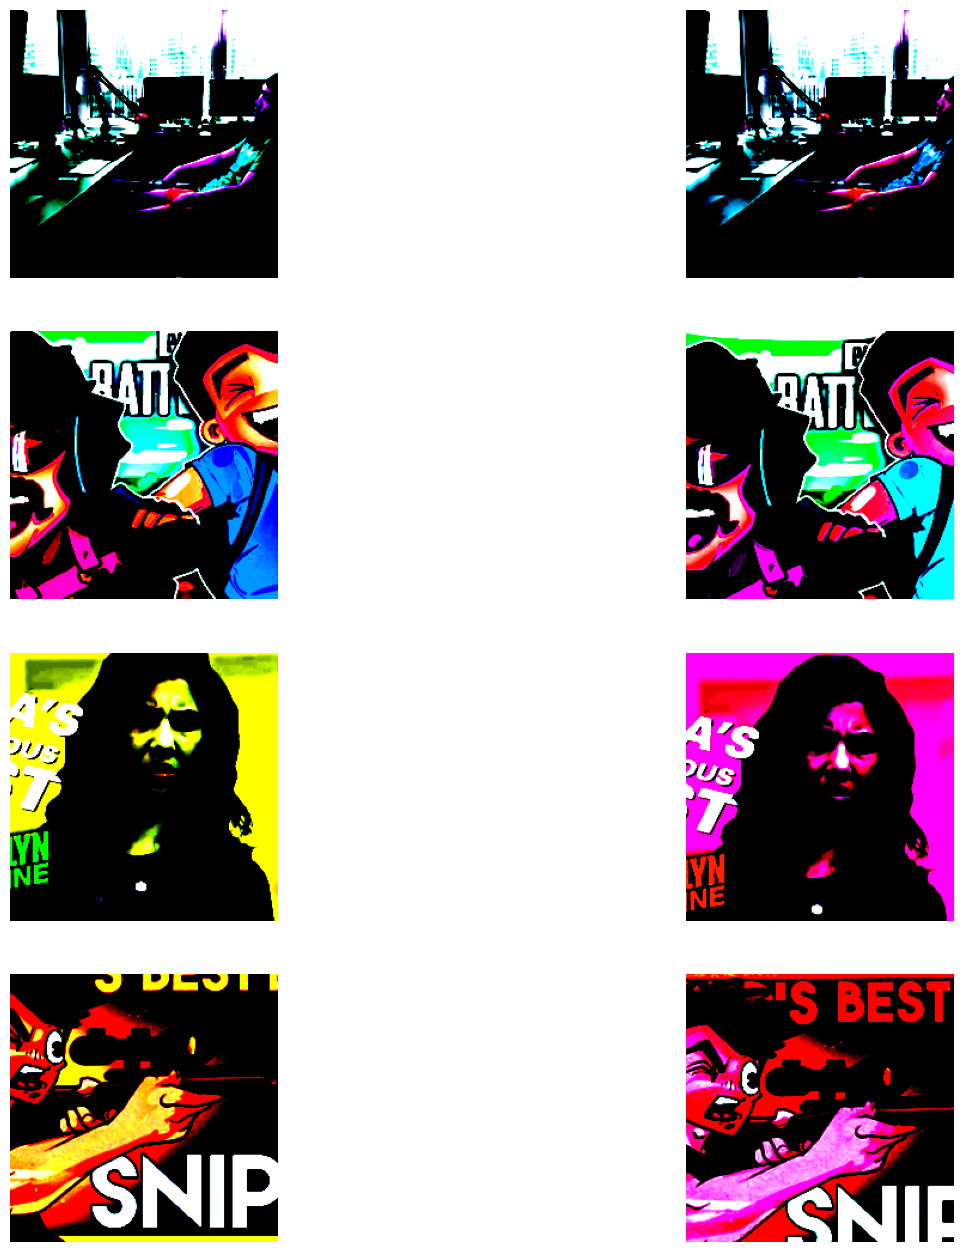

In [80]:

for (img,texts),(img2,texts2) in zip(train_dataloader,train_dataloader2):
    print(img.shape)
    print(img2.shape)
    print(texts.shape)
    print(texts2.shape)
    
    # print(img[0][0][0][0].item())
    plt.figure(figsize=(16, 16))
    num=0
    for i in range(4):
        a = img[num+i]
        a = a.numpy().transpose(1,2,0)
        plt.subplot(4, 2, 2*i + 1)
        # plt.title(text_list[num+i])
        plt.imshow(a)
        plt.axis("off")

        a = img2[num+i]

        a = a.numpy().transpose(1,2,0)
        plt.subplot(4, 2, 2*i + 2)
        # plt.title(new_list[num+i])
        plt.imshow(a)
        plt.axis("off")
    break

# LoRA + CLIP Models

count number of  parameters

In [82]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )
    return trainable_params, all_param


print('hugging face CLIP')
_,basic_model_params_num =  print_trainable_parameters(model)

hugging face CLIP
trainable params: 151277313 || all params: 151277313 || trainable%: 100.00


## hugging face CLIP config


In [ ]:
from transformers import CLIPConfig, CLIPModel

# Initializing a CLIPConfig with openai/clip-vit-base-patch32 style configuration
configuration = CLIPConfig()

# Initializing a CLIPModel (with random weights) from the openai/clip-vit-base-patch32 style configuration
model = CLIPModel(configuration)

# Accessing the model configuration
configuration = model.config

# We can also initialize a CLIPConfig from a CLIPTextConfig and a CLIPVisionConfig
from transformers import CLIPTextConfig, CLIPVisionConfig

# Initializing a CLIPText and CLIPVision configuration
config_text = CLIPTextConfig()
config_vision = CLIPVisionConfig()

config = CLIPConfig.from_text_vision_configs(config_text, config_vision)
config

CLIPConfig {
  "initializer_factor": 1.0,
  "logit_scale_init_value": 2.6592,
  "model_type": "clip",
  "projection_dim": 512,
  "text_config": {
    "model_type": "clip_text_model"
  },
  "transformers_version": "4.35.0",
  "vision_config": {
    "model_type": "clip_vision_model"
  }
}

# Hugging Face PEFT 
### we using PEFT(Parameter-Efficient Fine-Tuning ) adjust CLIP to LoRA CLIP model.

In [161]:
# from transformers import AutoModelForSeq2SeqLM
# model_name_or_path = "bigscience/mt0-large"
# tokenizer_name_or_path = "bigscience/mt0-large"

from transformers import CLIPProcessor, CLIPModel,AutoProcessor, AutoTokenizer

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

_,basis_params = print_trainable_parameters(model)

trainable params: 151277313 || all params: 151277313 || trainable%: 100.00


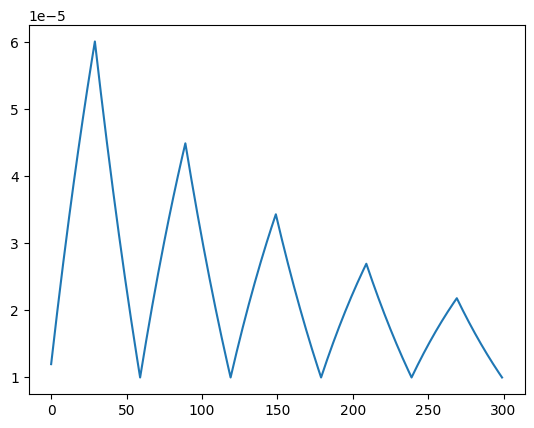

In [294]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

model = nn.Linear(1,1)
optimizer = torch.optim.Adam(model.parameters(), lr =  3e-5)
scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=70, T_mult=1, eta_max=1e-4,  T_up=17, gamma=0.9)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, 
                                            step_size_up=30, max_lr=7e-5, 
                                            gamma=0.994, 
                                            mode='exp_range' #'triangular', 'triangular2', 'exp_range'
                                            )
num_epochs = 20*15
lr_values = []
# Loop over epochs
for epoch in range(num_epochs):
    # Step the scheduler
    scheduler.step()
    # Get the current learning rate
    lr = optimizer.param_groups[0]['lr']
    # Append the learning rate to the list
    lr_values.append(lr)
plt.plot(lr_values)
# plt.show(lr_values)

In [259]:
# optimizer = torch.optim.Adam(model.parameters(), lr =  3e-5)
optimizer.param_groups[0]['lr']
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    initial_lr: 3e-05
    lr: 5.1472449306685266e-05
    maximize: False
    weight_decay: 0
)

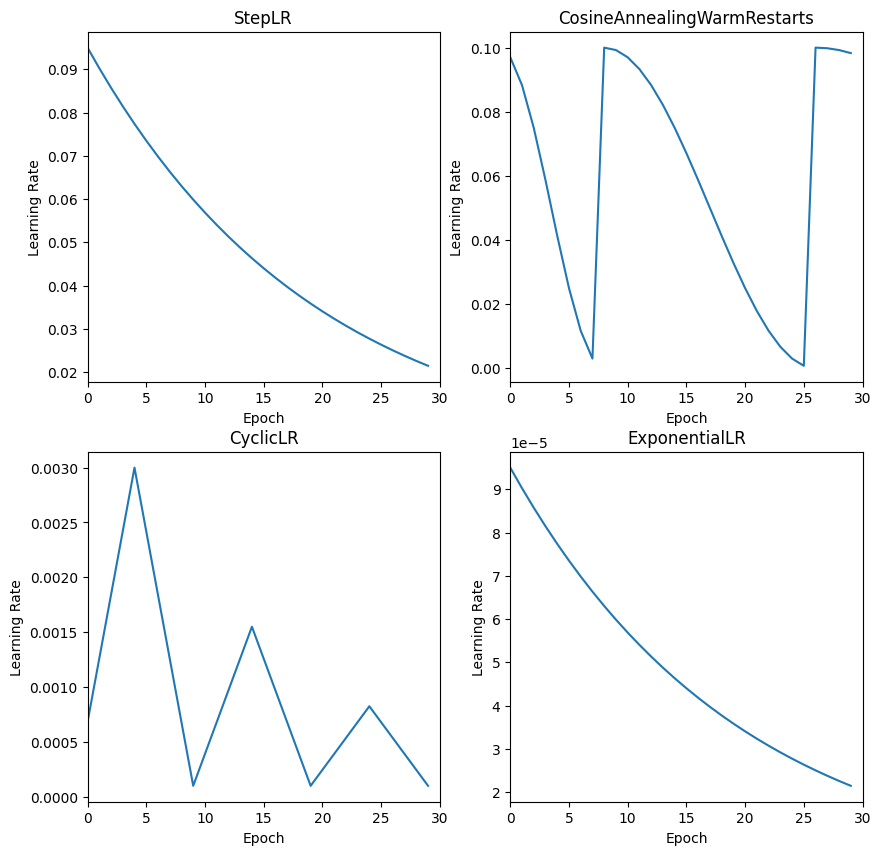

In [174]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts , CyclicLR, ExponentialLR,StepLR, CosineAnnealingLR
# optimizer = torch.optim.Adam(model.parameters(), lr = 0)
# scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=150, T_mult=1, eta_max=0.1,  T_up=10, gamma=0.5)

# Define the model
model = nn.Linear(1, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

num_epochs = 30
# Define list to store learning rate values
lr_values = []

n, m = 2, 2
fig, ax = plt.subplots(n, m, figsize=(10, 10))
lr_decay_step = 1
scheduler1 = StepLR(optimizer, lr_decay_step, gamma=0.95)
scheduler2 = CosineAnnealingWarmRestarts(optimizer, T_0=9, T_mult=2, eta_min=0, last_epoch=-1)
scheduler3 = CyclicLR(optimizer, base_lr=0.0001, max_lr=0.003, step_size_up=5, step_size_down=5, mode='triangular2', gamma=1.0, scale_fn=None, scale_mode='cycle', cycle_momentum=True, base_momentum=0.8, max_momentum=0.95, last_epoch=-1)
scheduler4 = ExponentialLR(optimizer, gamma=0.95)
for i in range(n):
    for j in range(m):
        if i == 0 and j == 0:
            scheduler = scheduler1
        elif i == 0 and j == 1: 
            scheduler = scheduler2
        elif i == 1 and j == 0:
            scheduler = scheduler3
        elif i == 1 and j == 1:
            scheduler = scheduler4
        # Loop over epochs
        for epoch in range(num_epochs):
            # Step the scheduler
            scheduler.step()
            # Get the current learning rate
            lr = optimizer.param_groups[0]['lr']
            # Append the learning rate to the list
            lr_values.append(lr)
        ax[i, j].plot(lr_values)
        x = f'{scheduler}'.split(' ')[0]
        ax[i, j].set_title(x[26:])
        ax[i, j].set_xlabel('Epoch')
        ax[i, j].set_xlim(0, num_epochs)
        ax[i, j].set_ylabel('Learning Rate')
        lr_values = []
plt.show()

In [162]:
from peft import get_peft_model, LoraConfig, TaskType

config = LoraConfig(
    task_type=TaskType.FEATURE_EXTRACTION, 
    inference_mode=False, 
    r=4, 
    lora_alpha=16, 
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj","k_proj","out_proj"], # PEFT를 적용할 모듈
    bias="none", # Bias usage
    
    # 여기를 붙이면 파라미터가 급격하게 늘어나는데 왜그런걸까? : encoder파라미터 저장.
    # modules_to_save=["encoder"], #save module list
)

lora_model = get_peft_model(model, config)
_,lora_params = print_trainable_parameters(lora_model)

print('파라미터 늘어난 비율 : ',lora_params/basis_params)

trainable params: 491520 || all params: 151768833 || trainable%: 0.32
파라미터 늘어난 비율 :  1.0032491322740509


In [163]:
import loralib as lora
# This sets requires_grad to False for all parameters without the string "lora_" in their names
lora.mark_only_lora_as_trainable(lora_model)

for name,params in lora_model.named_parameters():
    if params.requires_grad==True:
        print(name)
        break
    
# 살펴보면 전부 attention weight matrix에 lora가 적용되었고, 그 적용된 matrix만 
# grad값을 True로 만들었다.
# 다시 파라미터 개수를 새보면 정확하다.
_,lora_model_params_num=print_trainable_parameters(lora_model)
print(lora_model_params_num/basic_model_params_num)

print()
print('rank = 4이고,')
print('현재 지금 파라미터 개수가 491520이다 ')
print('rank를 2배로 늘리면 파라미터 개수도 2배가됨.')

base_model.model.text_model.encoder.layers.0.self_attn.k_proj.lora_A.default.weight
trainable params: 491520 || all params: 151768833 || trainable%: 0.32
1.0032491322740509

rank = 4이고,
현재 지금 파라미터 개수가 491520이다 
rank를 2배로 늘리면 파라미터 개수도 2배가됨.


In [166]:
for i,batch in enumerate(train_dataloader):

    images,texts = batch 

    images= images.to(device)
    texts = texts.to(device)
    dict1 = {}
    dict1['input_ids'] = texts
    dict1['pixel_values'] = images
    break
y = model(**dict1)
y.text_embeds.shape,y.image_embeds.shape

(torch.Size([16, 512]), torch.Size([16, 512]))

In [ ]:
import torch.optim as optim
from tqdm import tqdm 

device = "cuda" if torch.cuda.is_available() else "cpu"
print('out device :',device)


def convert_models_to_fp32(lora_model): 
    for p in lora_model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float() 


if device == 'cpu':
    lora_model.float()
else :
    lora_model.convert_weights(lora_model) # Actually this line is unnecessary since clip by default already on float16

loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()
optimizer = optim.Adam(lora_model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2) #Params used from paper, the lr is smaller, more safe for fine tuning to new dataset

EPOCH = 1
# add your own code to track the training progress.
for epoch in range(EPOCH):
    print("Epoch : ",epoch)
    for i,batch in enumerate(train_dataloader):
        optimizer.zero_grad()

        images,texts = batch 

        images= images.to(device)
        texts = texts.to(device)
        dict1 = {}
        dict1['input_ids'] = texts
        dict1['pixel_values'] = images
        
        # logits_per_image, logits_per_text = model(images, texts)
        # tensor.size(batch_size, batch_size)
        y = lora_model(**dict1)
        
        ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
        # tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  .... ,batch_size])
        
        total_loss = (loss_img(y.logits_per_image,ground_truth) + loss_txt(y.logits_per_text,ground_truth))/2
        total_loss.backward()
        print('i batch : ',i,'  !!loss :',total_loss)
        if device == 'cpu':
            optimizer.step()
        else : 
            convert_models_to_fp32(lora_model)
            optimizer.step()
            clip.model.convert_weights(lora_model)
        if i==3:
            break
    break

out device : cpu
Epoch :  0
i batch :  0   !!loss : tensor(2.7535, grad_fn=<DivBackward0>)
i batch :  1   !!loss : tensor(2.7826, grad_fn=<DivBackward0>)
i batch :  2   !!loss : tensor(2.7641, grad_fn=<DivBackward0>)
i batch :  3   !!loss : tensor(2.7754, grad_fn=<DivBackward0>)


In [ ]:
# 파라미터 개수 계산
parameter_count = sum(p.numel() for p in lora_model.parameters() if p.requires_grad)
print(parameter_count/1e6,'Million')

0.49152 Million


# variant's of loss function using simCLR, simCSE

## alignment만 수정. 

In [ ]:
import torch.optim as optim
from tqdm import tqdm

loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

# loss_alignment = nn.MSELoss()
loss_alignment = nn.CrossEntropyLoss()

optimizer = optim.Adam(lora_model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2) #Params used from paper, the lr is smaller, more safe for fine tuning to new dataset

EPOCH = 15
EPOCH = 1
# add your own code to track the training progress.
for epoch in tqdm(range(EPOCH)):
    print('##################')
    print("Epoch : ",epoch)
    print('##################')
    for step,((img,texts),(img2,texts2))in enumerate(zip(train_dataloader,train_dataloader2)):
        optimizer.zero_grad()

        images= img.to(device)
        texts = texts.to(device)
        
        images2= img2.to(device)
        texts2 = texts2.to(device)
        
        dict1 = {}
        dict1['input_ids'] = texts
        dict1['pixel_values'] = images
        
        dict2 = {}
        dict2['input_ids'] = texts2
        dict2['pixel_values'] = images2
        
        y1 = lora_model(**dict1)
        y2 = lora_model(**dict2)
        
        image_embeddings = y1.image_embeds
        text_embeddings = y1.text_embeds
        
        image_embeddings2 = y2.image_embeds
        text_embeddings2 = y2.text_embeds
        
        # cosine
        def cos_similarity(h1,h2,temperature=1.0):
            sim = torch.dot(h1,h2)/(torch.dot(h1,h1)*torch.dot(h2,h2))
            return -sim/temperature
        
        # list로 여러개 만드는것.
        alignment = cos_similarity(image_embeddings[0],image_embeddings2[0]).unsqueeze(0)
        for i in range(1,batch_size):
            h1 = image_embeddings[i]
            h2 = image_embeddings2[i]
            alignment =torch.concat((alignment,cos_similarity(h1,h2).unsqueeze(0)),dim=0)
        ground_truth = torch.ones(len(images),dtype=torch.long,device=device)
        # [1,1,1,...]
        
        
        # # 하나의 loss값.
        # alignment = torch.tensor(0.)
        # for i in range(batch_size):
        #     h1 = image_embeddings[i]
        #     h2 = image_embeddings2[i]
        #     alignment += cos_similarity(h1,h2)
        # ground_truth = torch.tensor(1.)
        
        ################# ground true 값 조정
        # ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
        # [1,2,3,4,]
        
        
        # loss function
        total_loss = torch.sum((ground_truth-alignment)**2/batch_size)
        # total_loss = -ground_truth*torch.log(alignment)
        # total_loss = loss_alignment(ground_truth,alignment)
        total_loss.backward()
        print(step,"'s batch  ",'  &loss :',total_loss)
        # if device == 'cpu':
        optimizer.step()
        if step==2:
            break
    break


  0%|          | 0/1 [00:00<?, ?it/s]

##################
Epoch :  0
##################
0 's batch     &loss : tensor(3.9620, grad_fn=<SumBackward0>)
1 's batch     &loss : tensor(3.9778, grad_fn=<SumBackward0>)
2 's batch     &loss : tensor(3.9543, grad_fn=<SumBackward0>)


  0%|          | 0/1 [00:35<?, ?it/s]

3 's batch     &loss : tensor(3.9658, grad_fn=<SumBackward0>)


# alignment & anisotropy 수정

In [ ]:
import torch.optim as optim
from tqdm import tqdm

loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

# loss_alignment = nn.MSELoss()
loss_alignment = nn.CrossEntropyLoss()

optimizer = optim.Adam(lora_model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2) #Params used from paper, the lr is smaller, more safe for fine tuning to new dataset



lora_model.to(device)
lora_model.train()

EPOCH = 15
EPOCH = 1
tau = 1/0.05
# add your own code to track the training progress.
for epoch in tqdm(range(EPOCH)):
    print('##################')
    print("Epoch : ",epoch)
    print('##################')
    for step,((img,texts),(img2,texts2))in enumerate(zip(train_dataloader,train_dataloader2)):
        optimizer.zero_grad()

        images= img.to(device)
        texts = texts.to(device)
        
        images2= img2.to(device)
        texts2 = texts2.to(device)
        
        dict1 = {}
        dict1['input_ids'] = texts
        dict1['pixel_values'] = images
        
        dict2 = {}
        dict2['input_ids'] = texts2
        dict2['pixel_values'] = images2
        
        y1 = lora_model(**dict1)
        y2 = lora_model(**dict2)
        
        image_embeddings = y1.image_embeds
        text_embeddings = y1.text_embeds
        
        image_embeddings2 = y2.image_embeds
        text_embeddings2 = y2.text_embeds
        
        # cosine
        # alignment_ii = -torch.log(F.cosine_similarity(image_embeddings,image_embeddings2))
        h1 = torch.randn(batch_size,512)
        alignment = -torch.log(F.cosine_similarity(h1,h1))
        alignment_it1 = -(tau*F.cosine_similarity(image_embeddings,text_embeddings))/batch_size
        alignment_it2 = -(tau*F.cosine_similarity(image_embeddings2,text_embeddings2))
        
        anisotropy = torch.empty_like(alignment)
        for i in range(batch_size):
            I1 = image_embeddings[i]
            I2 = image_embeddings2[i]
            T1 = text_embeddings[i]
            T2 = text_embeddings2[i]
            anisotropyj = 0
            for j in range(batch_size): 
                if i!=j:
                    anisotropyj+= F.cosine_similarity(image_embeddings2[i,:],text_embeddings2[j,:],dim=0)
                    anisotropyj+= F.cosine_similarity(image_embeddings[i,:],text_embeddings[j,:],dim=0)
            anisotropy[i] = anisotropyj/batch_size#*tau
            
                    
        
        # loss function
        total_loss = torch.sum(alignment_it1+alignment_it2+anisotropy)
        total_loss.backward()
        print(step,"'s batch  ",'  &loss :',total_loss)
        # if device == 'cpu':
        optimizer.step()
        if step==7:
            break
    break


  0%|          | 0/1 [00:00<?, ?it/s]

##################
Epoch :  0
##################
0 's batch     &loss : tensor(-47.1827, grad_fn=<SumBackward0>)
1 's batch     &loss : tensor(-51.6176, grad_fn=<SumBackward0>)
2 's batch     &loss : tensor(-49.7819, grad_fn=<SumBackward0>)
3 's batch     &loss : tensor(-53.7432, grad_fn=<SumBackward0>)
4 's batch     &loss : tensor(-46.7424, grad_fn=<SumBackward0>)
5 's batch     &loss : tensor(-52.3037, grad_fn=<SumBackward0>)
6 's batch     &loss : tensor(-55.9668, grad_fn=<SumBackward0>)


  0%|          | 0/1 [01:28<?, ?it/s]

7 's batch     &loss : tensor(-59.2528, grad_fn=<SumBackward0>)


In [ ]:
alignment_it1.mean(),alignment_it2.mean(),+anisotropy.mean(),

(tensor(0.1584, grad_fn=<MeanBackward0>),
 tensor(2.2981, grad_fn=<MeanBackward0>),
 tensor(-74.4310, grad_fn=<MeanBackward0>))

In [ ]:
anisotropy = torch.empty_like(alignment)
for i in range(batch_size):
    I1 = image_embeddings[i]
    I2 = image_embeddings2[i]
    T1 = text_embeddings[i]
    T2 = text_embeddings2[i]
    anisotropyj = torch.tensor([0.])
    for j in range(batch_size): 
        if i!=j:
            anisotropyj+= F.cosine_similarity(image_embeddings2[i,:],text_embeddings2[j,:],dim=0)
            anisotropyj+= F.cosine_similarity(image_embeddings[i,:],text_embeddings[j,:],dim=0)
        # anisotropy+= cos_similarity(image_embeddings[i],text_embeddings2[j]).unsqueeze(0)
        
    anisotropy[i] = anisotropyj
    
anisotropy

tensor([0.7089, 0.7323, 0.7677, 0.6654, 0.7404, 0.6813, 0.7442, 0.5649, 0.5656,
        0.7752, 0.7472, 0.7546, 0.8027, 0.7345, 0.4647, 0.5895],
       grad_fn=<CopySlices>)

In [ ]:
text = "안녕하세요 저는 신중현입니다. 당신의 이름은 무엇인지 궁금합니다. 알려주실 수 있나요? 당신은 바보군요 저는 천재입니다"
inputs = tokenizer([text], padding=True, return_tensors="np")
print('korean token')
print(inputs['input_ids'].shape)
text = "Hello, I'm Shin Joong-hyun. I wonder what your name is. Can you tell me? You're a fool I'm a genius"
inputs = tokenizer([text], padding=True, return_tensors="np")
print('english toekn')
print(inputs['input_ids'].shape)

#한국어냐 영어냐에따라 토큰수가 다르다.. 뭐 당연하지만, 한국어는 어떻게 할당하는지 궁금하네..

korean token
(1, 104)
english toekn
(1, 31)


In [ ]:
ground_truth = torch.tensor(1.)

# loss function
# total_loss = (ground_truth-alignment)**2
print(alignment)

total_loss = -ground_truth*torch.log(torch.exp(alignment))
print(total_loss)
torch.log(alignment)

tensor(-1.5183, grad_fn=<AddBackward0>)
tensor(1.5183, grad_fn=<MulBackward0>)


tensor(nan, grad_fn=<LogBackward0>)

# Objective function

<!--log \exp^ -->
$$
h_i = f(x_i)
$$
N = batch_size

sim  = cosine, mutual information, euclidean distance
## Loss function
$$
\mathcal{L} = \sum_{i=1}^{N} log \exp^ {-\frac{1}{\tau}  sim(h_i,h_i^+)} (Alignment)
$$
$$
+ \sum_{i=1}^{N} log \sum_{j \neq i}^{N} \exp^{\frac{1}{\tau} sim(h_i,h_j)} (Anisotropy)
$$

In [ ]:
# model, preprocess = clip.load("ViT-B/32",device=device,jit=False) #Must set jit=False for training

# model, preprocess = clip.load("ViT-B/32", device=device)
# checkpoint = torch.load("model_10.pt")

# # Use these 3 lines if you use default model setting(not training setting) of the clip. For example, if you set context_length to 100 since your string is very long during training, then assign 100 to checkpoint['model_state_dict']["context_length"] 
# # checkpoint['model_state_dict']["input_resolution"] = model.input_resolution #default is 224
# # checkpoint['model_state_dict']["context_length"] = model.context_length # default is 77
# # checkpoint['model_state_dict']["vocab_size"] = model.vocab_size 

# model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

# loss function modify

## cross entropy -> contrastive learning


In [ ]:
input = torch.randn(2, 2, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
input,target

(tensor([[-0.4380,  0.0920],
         [-0.3785, -0.7993]], requires_grad=True),
 tensor([1, 1, 1]))

In [ ]:
def validation_test(lora_model,valid_dataloader,valid_dataloader2):
    lora_model.eval()
    with torch.no_grad():
        for step,((img,texts),(img2,texts2))in enumerate(zip(valid_dataloader,valid_dataloader2)):
            images = img.to(device)
            texts = texts.to(device)
            
            images2= img2.to(device)
            texts2 = texts2.to(device)
            
            dict1 = {}
            dict1['input_ids'] = texts
            dict1['pixel_values'] = images
            
            dict2 = {}
            dict2['input_ids'] = texts2
            dict2['pixel_values'] = images2
            
            y1 = lora_model(**dict1)
            y2 = lora_model(**dict2)
            
            image_embeddings = y1.image_embeds
            text_embeddings = y1.text_embeds
            
            image_embeddings2 = y2.image_embeds
            text_embeddings2 = y2.text_embeds

        
            # cosine
            # alignment_ii = -torch.log(F.cosine_similarity(image_embeddings,image_embeddings2))
            h1 = torch.randn(batch_size,512)
            alignment = -torch.log(F.cosine_similarity(h1,h1))
            alignment_it1 = -(tau*F.cosine_similarity(image_embeddings,text_embeddings))/batch_size
            alignment_it2 = -(tau*F.cosine_similarity(image_embeddings2,text_embeddings2))
            
            anisotropy = torch.empty_like(alignment)
            for i in range(batch_size):
                I1 = image_embeddings[i]
                I2 = image_embeddings2[i]
                T1 = text_embeddings[i]
                T2 = text_embeddings2[i]
                anisotropyj = 0
                for j in range(batch_size): 
                    if i!=j:
                        anisotropyj+= F.cosine_similarity(image_embeddings2[i,:],text_embeddings2[j,:],dim=0)
                        anisotropyj+= F.cosine_similarity(image_embeddings[i,:],text_embeddings[j,:],dim=0)
                anisotropy[i] = anisotropyj/batch_size#*tau
            
            # loss function
            total_loss = torch.sum(alignment_it1+alignment_it2+anisotropy)
            print(step,"'s batch  ",'  &loss :',loss)

In [ ]:

# add your own code to track the training progress.
for epoch in tqdm(range(EPOCH)):
    print('##################')
    print("Epoch : ",epoch)
    print('##################')
    for step,((img,texts),(img2,texts2))in enumerate(zip(train_dataloader,train_dataloader2)):
        optimizer.zero_grad()

        images= img.to(device)
        texts = texts.to(device)
        
        images2= img2.to(device)
        texts2 = texts2.to(device)
        
        dict1 = {}
        dict1['input_ids'] = texts
        dict1['pixel_values'] = images
        
        dict2 = {}
        dict2['input_ids'] = texts2
        dict2['pixel_values'] = images2
        
        y1 = lora_model(**dict1)
        y2 = lora_model(**dict2)
        
        image_embeddings = y1.image_embeds
        text_embeddings = y1.text_embeds
        
        image_embeddings2 = y2.image_embeds
        text_embeddings2 = y2.text_embeds
        
        # cosine
        # alignment_ii = -torch.log(F.cosine_similarity(image_embeddings,image_embeddings2))
        h1 = torch.randn(batch_size,512)
        alignment = -torch.log(F.cosine_similarity(h1,h1))
        alignment_it1 = -(tau*F.cosine_similarity(image_embeddings,text_embeddings))/batch_size
        alignment_it2 = -(tau*F.cosine_similarity(image_embeddings2,text_embeddings2))
        
        anisotropy = torch.empty_like(alignment)
        for i in range(batch_size):
            I1 = image_embeddings[i]
            I2 = image_embeddings2[i]
            T1 = text_embeddings[i]
            T2 = text_embeddings2[i]
            anisotropyj = 0
            for j in range(batch_size): 
                if i!=j:
                    anisotropyj+= F.cosine_similarity(image_embeddings2[i,:],text_embeddings2[j,:],dim=0)
                    anisotropyj+= F.cosine_similarity(image_embeddings[i,:],text_embeddings[j,:],dim=0)
            anisotropy[i] = anisotropyj/batch_size#*tau
            
                    
        
        # loss function
        total_loss = torch.sum(alignment_it1+alignment_it2+anisotropy)
        total_loss.backward()
        print(step,"'s batch  ",'  &loss :',total_loss)
        # if device == 'cpu':
        optimizer.step()
        if step==7:
            break
    break


In [61]:
import pandas as pd
my_df = pd.DataFrame(data=[4,5,6,7], index=range(0,4), columns=['A'])
my_df.to_csv('hello.csv')

In [295]:
# 실험 결과
""" 
 0%|          | 0/15 [00:00<?, ?it/s]
##################
Epoch :  0
##################
0 's batch     &loss : 0.1842 alignment1,2 :  -0.088 -0.087  anisotropy : 0.359
lr : 1.2352941176470589e-05
10 's batch     &loss : 0.1743 alignment1,2 :  -0.088 -0.087  anisotropy : 0.349
lr : 3.5882352941176474e-05
20 's batch     &loss : 0.154 alignment1,2 :  -0.082 -0.082  anisotropy : 0.319
lr : 4.944045828160822e-05
####################
validation!!
  7%|▋         | 1/15 [02:48<39:23, 168.80s/it]
valid_loss : 0.11913358100822993 valid_alignment -0.07925071428571429 valid_anisotropy 0.2775714285714285
####################
##################
Epoch :  1
##################
0 's batch     &loss : 0.1229 alignment1,2 :  -0.082 -0.083  anisotropy : 0.287
lr : 4.5150224843232404e-05
10 's batch     &loss : 0.0728 alignment1,2 :  -0.076 -0.075  anisotropy : 0.223
lr : 3.527174332138136e-05
20 's batch     &loss : 0.027 alignment1,2 :  -0.063 -0.063  anisotropy : 0.153
lr : 2.359460292274325e-05
####################
validation!!
 13%|█▎        | 2/15 [05:33<36:06, 166.64s/it]
valid_loss : -0.021151634698201503 valid_alignment -0.05447428571428571 valid_anisotropy 0.08771428571428572
####################
##################
Epoch :  2
##################
0 's batch     &loss : -0.0209 alignment1,2 :  -0.058 -0.058  anisotropy : 0.095
lr : 1.564985485911338e-05
10 's batch     &loss : -0.0618 alignment1,2 :  -0.051 -0.047  anisotropy : 0.037
lr : 1.0315388441048063e-05
20 's batch     &loss : -0.1141 alignment1,2 :  -0.034 -0.03  anisotropy : -0.05
lr : 2.4411764705882358e-05
####################
validation!!
 20%|██        | 3/15 [08:19<33:12, 166.05s/it]
valid_loss : -0.2609853318759373 valid_alignment 0.011165714285714287 valid_anisotropy -0.28328571428571425
####################
##################
Epoch :  3
##################
0 's batch     &loss : -0.2691 alignment1,2 :  0.007 0.014  anisotropy : -0.29
lr : 4.0882352941176474e-05
10 's batch     &loss : -0.6387 alignment1,2 :  0.119 0.145  anisotropy : -0.902
lr : 4.3068999092408084e-05
20 's batch     &loss : -0.9923 alignment1,2 :  0.224 0.236  anisotropy : -1.452
lr : 3.594886354778804e-05
####################
validation!!
 27%|██▋       | 4/15 [11:04<30:22, 165.65s/it]
valid_loss : -1.1569719825472151 valid_alignment 0.26851714285714284 valid_anisotropy -1.6938571428571427
####################
##################
Epoch :  4
##################
0 's batch     &loss : -1.1616 alignment1,2 :  0.265 0.274  anisotropy : -1.7
lr : 2.8018583236894797e-05
10 's batch     &loss : -1.2388 alignment1,2 :  0.284 0.292  anisotropy : -1.814
lr : 1.8158090885616163e-05
20 's batch     &loss : -1.2759 alignment1,2 :  0.294 0.299  anisotropy : -1.869
lr : 1.1484951698247182e-05
####################
validation!!
 33%|███▎      | 5/15 [13:49<27:35, 165.53s/it]
valid_loss : -1.286742857524327 valid_alignment 0.2990628571428572 valid_anisotropy -1.8848571428571428
####################
##################
Epoch :  5
##################
0 's batch     &loss : -1.2888 alignment1,2 :  0.298 0.301  anisotropy : -1.888
lr : 1.1794117647058825e-05
10 's batch     &loss : -1.302 alignment1,2 :  0.301 0.305  anisotropy : -1.907
lr : 2.973529411764706e-05
20 's batch     &loss : -1.3209 alignment1,2 :  0.306 0.308  anisotropy : -1.935
lr : 4.007334943972627e-05
####################
validation!!
 40%|████      | 6/15 [16:34<24:47, 165.29s/it]
valid_loss : -1.3272401094436646 valid_alignment 0.30861857142857135 valid_anisotropy -1.9444285714285716
####################
##################
Epoch :  6
##################
0 's batch     &loss : -1.3287 alignment1,2 :  0.308 0.31  anisotropy : -1.947
lr : 3.680204644296471e-05
10 's batch     &loss : -1.3303 alignment1,2 :  0.308 0.31  anisotropy : -1.949
lr : 2.9269704282553284e-05
20 's batch     &loss : -1.3333 alignment1,2 :  0.309 0.311  anisotropy : -1.953
lr : 2.0365884728591728e-05
####################
validation!!
 47%|████▋     | 7/15 [19:19<22:00, 165.06s/it]
valid_loss : -1.3337960583823067 valid_alignment 0.3101642857142857 valid_anisotropy -1.954
####################
##################
Epoch :  7
##################
0 's batch     &loss : -1.3349 alignment1,2 :  0.31 0.311  anisotropy : -1.956
lr : 1.4308014330073953e-05
10 's batch     &loss : -1.3337 alignment1,2 :  0.309 0.311  anisotropy : -1.954
lr : 1.024048368629915e-05
20 's batch     &loss : -1.335 alignment1,2 :  0.31 0.311  anisotropy : -1.956
lr : 2.0891176470588238e-05
####################
validation!!
 53%|█████▎    | 8/15 [22:04<19:15, 165.04s/it]
valid_loss : -1.335474235670907 valid_alignment 0.31056000000000006 valid_anisotropy -1.9565714285714286
####################
##################
Epoch :  8
##################
0 's batch     &loss : -1.3364 alignment1,2 :  0.311 0.311  anisotropy : -1.958
lr : 3.333823529411765e-05
10 's batch     &loss : -1.336 alignment1,2 :  0.31 0.311  anisotropy : -1.957
lr : 3.499071502840554e-05
20 's batch     &loss : -1.3373 alignment1,2 :  0.311 0.311  anisotropy : -1.959
lr : 2.9609926881114104e-05
####################
validation!!
 60%|██████    | 9/15 [24:48<16:29, 164.99s/it]
valid_loss : -1.337592499596732 valid_alignment 0.31105571428571427 valid_anisotropy -1.9598571428571427
####################
##################
Epoch :  9
##################
0 's batch     &loss : -1.3383 alignment1,2 :  0.311 0.311  anisotropy : -1.961
lr : 2.3616900760453353e-05
10 's batch     &loss : -1.3375 alignment1,2 :  0.311 0.311  anisotropy : -1.96
lr : 1.6165185826415645e-05
20 's batch     &loss : -1.3383 alignment1,2 :  0.311 0.311  anisotropy : -1.961
lr : 1.1122199211961085e-05
####################
validation!!
 67%|██████▋   | 10/15 [27:34<13:45, 165.04s/it]
valid_loss : -1.3382552010672433 valid_alignment 0.3112121428571429 valid_anisotropy -1.960857142857143
####################
##################
Epoch :  10
##################
0 's batch     &loss : -1.3389 alignment1,2 :  0.311 0.312  anisotropy : -1.962
lr : 1.1341470588235296e-05
10 's batch     &loss : -1.3381 alignment1,2 :  0.311 0.311  anisotropy : -1.96
lr : 2.4756176470588235e-05
20 's batch     &loss : -1.3389 alignment1,2 :  0.311 0.312  anisotropy : -1.962
lr : 3.2485991277801886e-05
####################
validation!!
 73%|███████▎  | 11/15 [30:18<10:58, 164.73s/it]
valid_loss : -1.3390825646264213 valid_alignment 0.3114064285714286 valid_anisotropy -1.961857142857143
####################
##################
Epoch :  11
##################
0 's batch     &loss : -1.3397 alignment1,2 :  0.311 0.312  anisotropy : -1.963
lr : 3.0040021938747873e-05
10 's batch     &loss : -1.3391 alignment1,2 :  0.311 0.312  anisotropy : -1.962
lr : 2.440805266110255e-05
10 's batch     &loss : -1.3395 alignment1,2 :  0.311 0.312  anisotropy : -1.962
lr : 1.0179810834952527e-05
20 's batch     &loss : -1.3399 alignment1,2 :  0.311 0.312  anisotropy : -1.963
lr : 1.8039500000000002e-05
10 's batch     &loss : -1.3399 alignment1,2 :  0.311 0.312  anisotropy : -1.963
lr : 2.844730493656348e-05
20 's batch     &loss : -1.3404 alignment1,2 :  0.312 0.312  anisotropy : -1.964
lr : 2.447538818110822e-05
####################
validation!!
 93%|█████████▎| 14/15 [38:31<02:44, 164.59s/it]
valid_loss : -1.340464472770691 valid_alignment 0.31172999999999995 valid_anisotropy -1.964
####################
##################
Epoch :  14
##################
0 's batch     &loss : -1.3409 alignment1,2 :  0.312 0.312  anisotropy : -1.965
lr : 2.0051537954535784e-05
10 's batch     &loss : -1.3403 alignment1,2 :  0.311 0.312  anisotropy : -1.964
lr : 1.4550932728463223e-05
"""

" \n 0%|          | 0/15 [00:00<?, ?it/s]\n##################\nEpoch :  0\n##################\n0 's batch     &loss : 0.1842 alignment1,2 :  -0.088 -0.087  anisotropy : 0.359\nlr : 1.2352941176470589e-05\n10 's batch     &loss : 0.1743 alignment1,2 :  -0.088 -0.087  anisotropy : 0.349\nlr : 3.5882352941176474e-05\n20 's batch     &loss : 0.154 alignment1,2 :  -0.082 -0.082  anisotropy : 0.319\nlr : 4.944045828160822e-05\n####################\nvalidation!!\n  7%|▋         | 1/15 [02:48<39:23, 168.80s/it]\nvalid_loss : 0.11913358100822993 valid_alignment -0.07925071428571429 valid_anisotropy 0.2775714285714285\n####################\n##################\nEpoch :  1\n##################\n0 's batch     &loss : 0.1229 alignment1,2 :  -0.082 -0.083  anisotropy : 0.287\nlr : 4.5150224843232404e-05\n10 's batch     &loss : 0.0728 alignment1,2 :  -0.076 -0.075  anisotropy : 0.223\nlr : 3.527174332138136e-05\n20 's batch     &loss : 0.027 alignment1,2 :  -0.063 -0.063  anisotropy : 0.153\nlr : 2.3